In [15]:
import numpy as np
from scipy.stats import poisson
from sklearn.utils import resample
import matplotlib.pyplot as plt

def pan_private_uniformity(eps, data, k, alpha):
    #k = 20
    bins = np.linspace(0,1,k)
    m_prime = poisson.rvs(mu=m, size=1)
    #print('m_prime is: ' + str(m_prime))
    data_poissoned = resample(data, replace=True, n_samples=m_prime.item())
    
    #add normal noise here if you want to test the non-uniform case
    #normal_noise = np.random.normal(loc=0.0, scale=5.0, size = k-1)

    histogram = np.random.laplace(loc=0.0, scale=1/eps, size = k-1)
    histogram += np.histogram(a=data_poissoned,bins=bins)[0]
    histogram += np.random.laplace(loc=0.0, scale=1/eps, size = k-1)
    #histogram += normal_noise

    z_prime = np.sum(((histogram - m/k)**2 - histogram) / (m/k))

    
    t_u = 1/100 * alpha**2 * m + 4*(k**2)/(eps**2 * m) + 24*np.sqrt(2) * (k**(3/2)) / (eps**2 * m)
    t_u += 16*np.sqrt(2) * k /(eps*np.sqrt(m)) + 8*np.sqrt(2)*(k**(3/2)) / (eps*m)
    
    return z_prime, t_u

As we note in the paper, the Laplaced chi-square statistic has huge variance! We can see below that even if we meet the required sample complexity, we aren't guaranteed to get a consistently "good" answer. Though the variance does seem to decay with larger n, even in log form, this may not be particularly useful for actual hypothesis testing. We may need even larger samples to begin to see consistency. 

Below, we test uniform data over a large number of experiments to see how many of these tests return "uniform" like they actually should. 

In [26]:
np.random.seed(42)

eps = 1
m = 500 
k = 20
data = np.random.uniform(0,1,m)
alpha = 2/3

num_experiments = 1000
count = 0
for experiment in range(num_experiments):
    z_prime, t_u = pan_private_uniformity(1, data=data, k=k, alpha=alpha)
    #print(z_prime, t_u)
    if z_prime > t_u:
        count += 1
    else:
        pass
print(str(count / num_experiments) + ' of tests identified not-uniform data')

0.094 of tests identified not-uniform data


We can see from the fraction above that the tester seems to mostly identify the uniformity correctly, especially since we have so many samples. We also note that we are far above the theoretical sample complexity for actual privacy (500 >> 25). However, these two things are different in terms of actual utility. As we note in the paper, the variance scales differently for Laplace mechanisms than the sample complexity.

In [17]:
#sample complexity required for eps-DP
print(str(np.round(k**(3/4)/ (alpha*eps) + np.sqrt(k)/alpha**2, 2)) + ' samples for privacy' )

24.25 samples for privacy


In [18]:
variance_list = []
num_experiments = 200
for size in np.arange(10,1000,10):
    z_prime_list = []
    for experiment in range(num_experiments):
        z_prime, t_u = pan_private_uniformity(1, data=np.random.uniform(0,1,size), k=k, alpha=alpha)
        z_prime_list.append(z_prime)
        
    variance_list.append(np.var(z_prime_list))

Text(0, 0.5, 'Log MSE')

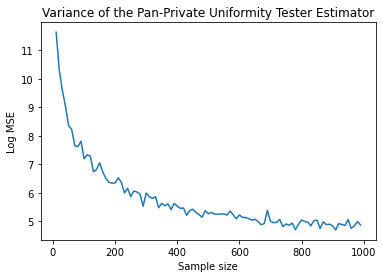

In [19]:
plt.plot(np.arange(10,1000,10), np.log(variance_list))
plt.title('Variance of the Pan-Private Uniformity Tester Estimator')
plt.xlabel('Sample size')
plt.ylabel('Log MSE')

For small sample sizes, the estimator variance is incredibly high compared to the threshold!

### RAPPOR: Encode, Perturb, Aggregate

In [20]:
def locally_private_uniformity(eps, data, k, alpha):
    #encode
    bins = np.linspace(0,1,k)
    k_ary_encodings = np.zeros((m, k-1))
    for d in range(len(data)):
        for b in range(len(bins)-1):
            #print(b, b+1)
            #print(bins[b], bins[b+1])
            if (data[d] >= bins[b]) & (data[d] <= bins[b+1]):
                k_ary_encodings[d, b] = 1
            else:
                pass
    
    #perturb
    perturb_matrix = np.random.uniform(0,1,size=(m,k-1))
    p_flip = 1 / (np.e**(eps/2)+1 )

    for d in range(len(data)):
        for b in range(len(bins)-1):
            if perturb_matrix[d,b] < p_flip:
                if k_ary_encodings[d,b] == 0:
                    k_ary_encodings[d,b] = 1
                elif k_ary_encodings[d,b] == 1:
                    k_ary_encodings[d,b] = 0
            else:
                pass
            
    #aggregate
    a_R = (np.e**(eps/2) - 1)/ (np.e**(eps/2) + 1)
    b_R = 1/ (np.e**(eps/2) + 1)

    #aggregate
    histogram = k_ary_encodings.sum(axis=0)
    histogram = (histogram - m*(p_flip)) / (a_R)
    #histogram
    
    return histogram

In [21]:
bins = np.linspace(0,1,k)
k_ary_encodings = np.zeros((m, k-1))
for d in range(len(data)):
    for b in range(len(bins)-1):
        #print(b, b+1)
        #print(bins[b], bins[b+1])
        if (data[d] >= bins[b]) & (data[d] <= bins[b+1]):
            k_ary_encodings[d, b] = 1
        else:
            pass
    

Let's use the data from the previous step, with m=500 data points. As we can see below, for a small privacy budget the bit flippings mess up our counts a lot even after debiasing. 

In [28]:
np.random.seed(42)
eps = 1
private = locally_private_uniformity(eps=eps, data=data, k=k, alpha=alpha)
print(str(private.sum(axis=0)) + " values in the LDP histogram")

671.0948230914777 values in the LDP histogram


Below, we check that the distance between the histograms, measured by the l2 norm, is indeed decreasing as the privacy budget increases. The plot below meets the eye test, but we note that at epsilon=1, we have a long way to go before we can even get remotely close to small error.  

For this privacy budget, the threshold is basically all noise, and this almost completely unusable even though we've met the required privacy levels. 

Text(0, 0.5, 'L2 Distance')

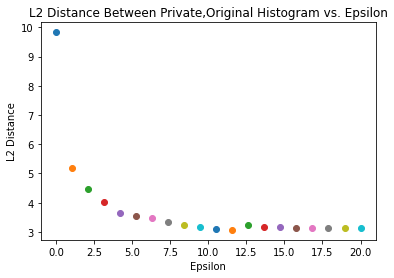

In [29]:
import matplotlib.pyplot as plt

eps_grid = np.linspace(0.01, 20, 20)

for e in eps_grid:
    private = locally_private_uniformity(eps=e, data=data, k=k, alpha=alpha)
    distance = np.linalg.norm(private - k_ary_encodings.sum(axis=0))
    plt.scatter(e, np.log(distance))
plt.title('L2 Distance Between Private,Original Histogram vs. Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('L2 Distance')

In [10]:
eps = 1
a_R = (np.e**(eps/2) - 1)/ (np.e**(eps/2) + 1)
b_R = 1/ (np.e**(eps/2) + 1)

t_u_vals = (private - (m -1)*(a_R/k + b_R))**2 - private
t_u_vals += k * (m-1)*(a_R/k + b_R)**2
t_u_rappor = np.sum(t_u_vals)

In [11]:
alpha = 1/3
thresh = m * (m-1) * a_R**2 * alpha**2 / k
print(t_u_rappor, m**2 * alpha**2 / k, thresh)

565830.0367119259 1388.888888888889 83.14608457115943


The scaling on the local model motivates the shuffle mechanism. We can solve for the required privacy budget using the theorem mentioned below and in the paper. By privacy amplification, this budget will be larger for a fixed local budget, or we can add less noise in the shuffle protocol. 

In [12]:
from scipy.optimize import fsolve
import random

def shuffle_local_randomizer_eps(n=100):
    #Thm 3.1 of https://arxiv.org/pdf/2012.12803.pdf

    #define constants to clean up polynomial for root-finding
    #we do not define eps here because we solve for eps = ln(...)
    #so for eps=1, the inside ... equals e^1

    delta = 10**(-5)
    a = np.log(4/delta)
    k = (np.e - 1)/8
    

    f = lambda x: np.sqrt(a/n) * x**(3/2) + x**2 / n - np.sqrt(a/n) * x**(1/2) - x/n - k*x - k

    #this function is a weird artifact of having to give fsolve a good starting guess
    #the rootfinder will get lost if we don't help it out
    init_guess_start = 2**(np.log(n) - 4)

    x_val = np.max(fsolve(f, x0=[init_guess_start,100]))
    eps_0 = np.log(x_val)

    return eps_0

In [13]:
n_vec = np.arange(100,20000, 500)
local_epsilons = [shuffle_local_randomizer_eps(n=n_vec[i]) for i in range(len(n_vec))]

Text(0, 0.5, '$\\epsilon_0$')

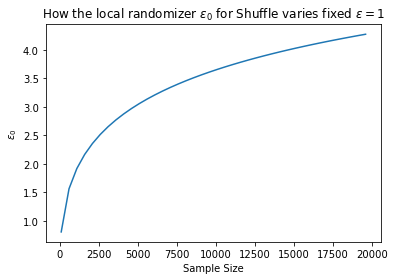

In [14]:
plt.plot(n_vec, local_epsilons)
plt.title(r'How the local randomizer $\epsilon_0$ for Shuffle varies fixed $\epsilon=1$')
plt.xlabel('Sample Size')
plt.ylabel(r'$\epsilon_0$')